<font size="5">Build Your Own ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets

    
- Determine water body polygons


- Build the Digital Elevation Model



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [1]:
import sys
import os
path = os.getcwd() + '/'
where_to_mount = '/content/drive/'

from google.colab import drive
from google.colab import auth
drive.mount(where_to_mount, force_remount=True)

mounted_drive = where_to_mount + 'MyDrive/'

Mounted at /content/drive/


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [2]:
import os
os.chdir(mounted_drive)
if os.path.isdir(mounted_drive + 'komo_estuary_tutorial'):
  print('## Updating the local git repository \n')
  os.chdir(mounted_drive + '/komo_estuary_tutorial')
  ! git pull 
else:
  print('## Pulling the git repository with files for the tutorial\n')
  ! git clone https://github.com/achri19/komo_estuary_tutorial.git

print('\n## Installing the Python packages needed for these tutorials\n')
!/bin/bash $mounted_drive/komo_estuary_tutorial/install_packages.sh



## Updating the local git repository 

Already up to date.

## Installing the Python packages needed for these tutorials

(1) Install pip packages to /content/drive/MyDrive/installations
nose mpi4py triangle Pmw pymetis cmocean geopandas fiona pygeos rasterio rasterstats scikit-fmm rtree pyTMD Orinoco
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
https://github.com/GeoscienceAustralia/anuga_core
(5) Install anuga
(7) Completed


In [3]:
!unzip -n komo_starter.zip -d $mounted_drive 


Archive:  komo_starter.zip


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [4]:
path = mounted_drive + 'processing/'
path_code = path + 'code/'
path_templates = path +  'templates/'
path_configs = path + 'configs/'
path_ancillary = path + 'ancillary/'
sys.path.insert(1,path_code)


<font size=5> Step #4: Now we will import the Python packages we need. <font> 




In [5]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
import pygeos
import pyTMD


In [6]:
from BYOM_Utilities_V1 import (build_directory,
                               get_extent_parameters,
                               setup_AOI_files, 
                               make_polygons,
                               make_channel_networks,
                               make_model_foundation, 
                               set_boundary_conditions, 
                               make_watermask,
                               more_opening)

<font size='5' color = 'red' > Building the DEM STEP #1: <br> Set the AOI again and make sure the working directory is set.  </font>


In [7]:
AOI = 'komo'

Path((mounted_drive + AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(mounted_drive, AOI)
print(working_path)



Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/komo/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_F

<font size='5' color = 'red' > Building the DEM STEP #2: <br> Here we set the necessary configuration parameters and then get extent coordinates for the model </font>


In [8]:
parameters = pd.DataFrame()
parameters['AOI'] = [AOI]
parameters['RiverOceanBoundary'] = '1260'
parameters['Discharge'] = '426'

#Method parameters:
parameters['LandcoverMethod'] = 'WorldCover'
parameters['LandElevMethod'] = 'GLO30'
parameters['OceanElevMethod'] = 'GEBCO'
parameters['LowerRiverElevMethod'] = 'plane'
parameters['UpperRiverElevMethod'] = 'wdpower'
parameters['WetlandElevMethod'] = 'constant_0.5'
parameters['LakeElevMethod'] = 'constant_1'
parameters['ManningLUT'] = 'default'
parameters['WetlandClass'] = '90'

#Coefficients for determining bathymetry:
parameters['WD_POWERA_upper'] = '0.0606'
parameters['WD_POWERB_upper'] = '0.7732'

#Max thresholds:
parameters['MaxOceanDepth'] = '-300'
parameters['MaxNearshoreDepth'] = '-300'
parameters['MaxRiverDepth'] = '-300'
parameters['MaxRiverWidth'] = '756'



In [9]:
ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

##################### AOI extent is set by: komo_input.shp
The input shapefile is not in the correction projection (EPSG 4326), reprojecting to EPSG 4326

[Step 2][Setup_AOI_Files][Determine EPSG code and UTM zone] .......

##################### ANUGA Models must be in UTM
##################### UTM Zone: 32n
##################### EPSG: 32232 

[Step 2][Setup_AOI_Files][Extending AOI by 1000m] .......


[Step 2][Setup_AOI_Files][Setting up AOI extent] .......

##################### AOI bounds are : 501790, -2260, 610150, 64700
##################### Approximate area of AOI extent is 7256.0 km^2

[Step 2][Setup_AOI_Files][Downloading GEBCO Dataset as reference for projection, resolution, etc] .......


[S

Text(0.5, 1.0, 'GEBCO Bathymetry resampled to 10m resolution')

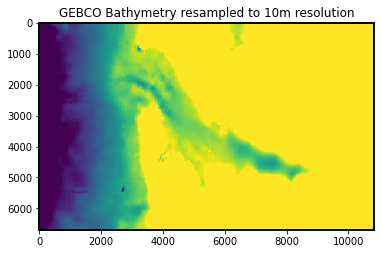

In [10]:
plt.imshow(ref_10m.read(1),vmin=-50,vmax=0)
plt.title('GEBCO Bathymetry resampled to 10m resolution')

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [11]:
parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
print(parameters.iloc[0] )

Unnamed: 0                         0
AOI                             komo
RiverOceanBoundary              1260
Discharge                        426
LandcoverMethod           WorldCover
LandElevMethod                 GLO30
OceanElevMethod                GEBCO
LowerRiverElevMethod           plane
UpperRiverElevMethod         wdpower
WetlandElevMethod       constant_0.5
LakeElevMethod            constant_1
ManningLUT                   default
WetlandClass                      90
WD_POWERA_upper               0.0606
WD_POWERB_upper               0.7732
MaxOceanDepth                   -300
MaxNearshoreDepth               -300
MaxRiverDepth                   -300
MaxRiverWidth                    756
ulx                           501794
lry                            -2259
lrx                           610154
uly                            64701
EPSG                           32232
Name: 0, dtype: object


<font size='5' color = 'red' > Building the DEM STEP #2b: <br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [12]:
ref = setup_AOI_files(path,
                    AOI,
                    folders,
                    res,
                    parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

The input shapefile is not in the correction projection (EPSG 4326), reprojecting to EPSG 4326
##################### Reference raster is komo_GEBCO_30.tif
##################### This profile will be used for all future warping
##################### Resolution is 30m

[Step 2][Setup_AOI_Files][Compiling OCEAN elevation dataset] .......

##################### Ocean elevation set with:  GEBCO

[Step 2][Setup_AOI_Files][Compiling LAND elevation dataset] .......

##################### Land elevation set with: GLO30

[Step 2][Setup_AOI_Files][Compiling Landcover Classification Maps] .......

##################### Landcover types based on: WorldCover

[Step 2][Setup_AOI_Files][Loading Global Mangrove Watch ] .

<font size='5' color = 'red' > The EPSG coordinate reference system must be is in UTM </font>


In [13]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]


Text(0.5, 1.0, 'WorldCover Landcover Map')

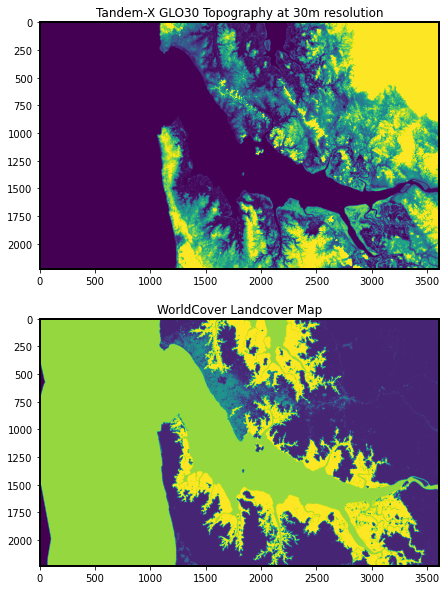

In [14]:
#ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
glo30 = rasterio.open('%s/%s_GLO30_topo_%s.tif' %(folders[8],AOI,res))
landcover = rasterio.open('%s/%s_WorldCover_%s.tif' %(folders[8],AOI,res))


fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(10,10))
ax1.imshow(glo30.read(1),vmin=0,vmax=50)
ax1.set_title('Tandem-X GLO30 Topography at 30m resolution')

ax2.imshow(landcover.read(1))
ax2.set_title('WorldCover Landcover Map')


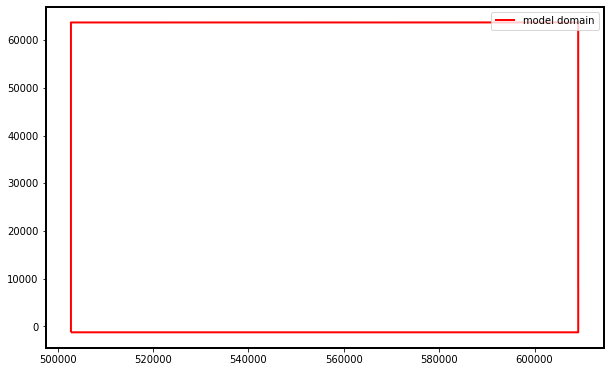

In [15]:
model_domain = gpd.read_file('%s%s_modeldomain.shp' %(folders[7],AOI))

fig,ax = plt.subplots(figsize=(10,10))
model_domain.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 2,ax=ax,label = 'model domain') #Use your second dataframe

plt.legend()

<font size='5' color = 'red' > Building the DEM STEP #3: <br> Clean, filter, smooth the water mask you made in the previous notebook </font>



In [16]:
#ref_10m = rasterio.open('%s/%s_GEBCO_10.tif' %(folders[8],AOI))
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,False, False)
how_much_opening = 3
more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)





##############################################################################################
#################################[Step 3A][Make_Watermask]####################################
##############################################################################################


[Step 2][Setup_AOI_Files][Compiling Water Masks] .......

##################### Google Earth Engine water mask file : komo_ndvimin_ndwimin_clustered_finalwatermask.tif

[Step 3A][Make_Watermask][Load Hydropolys] .......


[Step 3A][Make_Watermask][Load SWOT PLD lakes] .......


[Step 3A][Make_Watermask][Smoothing water and land masks] .......


[Step 3A][Make_Watermask][Start with the GEE watermask at 10m resolution] .......


[Step 3A][Make_Watermask][Removing wetland and agriculture areas from water mask] ......


[Step 3A][Make_Watermask][Determine whether 0 or 1 is water in GEE watermask] ......


[Step 3A][Make_Watermask][Update water mask to remove mangroves, crops] ......


[Step 3A][Make_Water

In [17]:
print(watermaskname)
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s/%s_watermask_10.tif %s/%s_watermask_%s.tif '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8],AOI,folders[8],AOI,res,ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s/%s_landmask_10.tif %s/%s_landmask_%s.tif '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8],AOI,folders[8],AOI,res,ulx,lry,lrx,uly))


komo_ndvimin_ndwimin_clustered_finalwatermask


(1500.0, 2000.0, 2000.0, 1500.0)

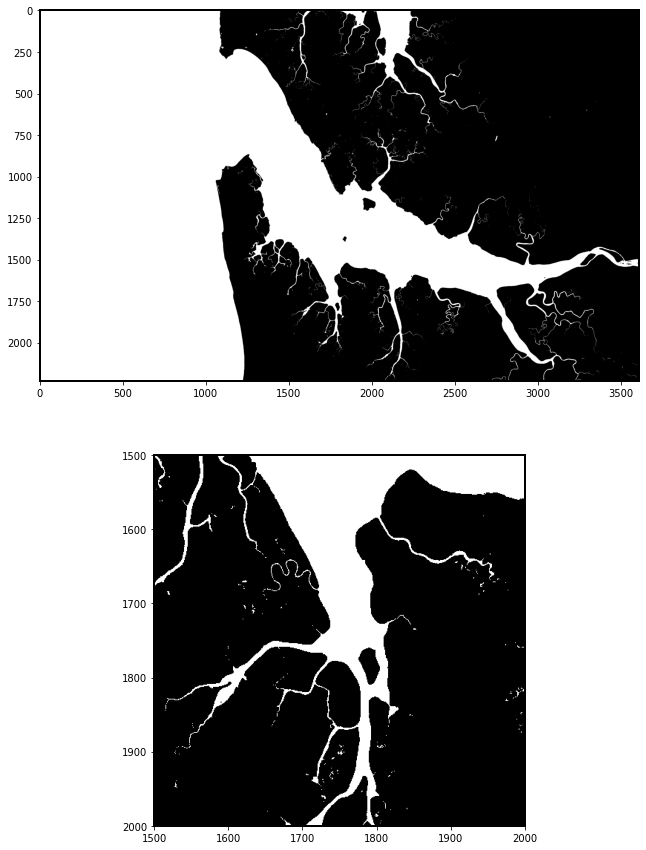

In [18]:
watermask = rasterio.open('%s%s_watermask_%s.tif' %(folders[8],AOI,res)).read(1)

fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(15,15))
ax1.imshow(watermask,'gray')

ax2.imshow(watermask,'gray')
ax2.axis([1500,2000, 2000,1500])

<font size='5' color = 'red' > Building the DEM STEP #4: <br> Make polygons of each land cover type: ocean, lake, river, land</font>


In [19]:
make_polygons(AOI,
                folders,
                parameters,
                ref,
                watermaskname,
                path_templates,False)






##############################################################################################
################################[Step 4][Make_Polygons]######################################
##############################################################################################


[Step 4][Make_Polygons][Open land/water mask] .......

##################### Water delineated with komo_ndvimin_ndwimin_clustered_finalwatermask_30


ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_lakes_30b.shp: No such file or directory
ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_fulloceans_30b.shp: No such file or directory



[Step 4][Make_Polygons][All initial water from Hydropolys and HydroLAKES] .......


[Step 4][Make_Polygons][Lakes from Hydropolys Type "Lake" and HydroLAKES] .......

##################### Lake polygons saved to /Setup_Files/Setup_SHP/komo_lakes_30.shp

[Step 4][Make_Polygons][Oceans from Hydropolys Type Ocean or Sea] .......

##################### Ocean polygons saved to /Setup_Files/Setup_SHP/komo_fulloceans_30.shp


ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_ocean_and_lake_30b.shp: No such file or directory



[Step 4][Make_Polygons][Ocean and lakes] .......



ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_water_connected_30b.shp: No such file or directory


##################### Ocean and lake polygons saved to /content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_ocean_lakes_30.shp

[Step 4][Make_Polygons][Find connected water, starting with largest ocean polygon] .......



ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_rivers_30b.shp: No such file or directory


##################### All water connected to ocean polygons saved to /Setup_Files/Setup_SHP/komo_water_connected_30.shp

[Step 4][Make_Polygons][River from water that is not lake or ocean] .......

##################### River polygons saved to /Setup_Files/Setup_SHP/komo_rivers_30.shp


ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_water_connected_and_lakes_30b.shp: No such file or directory



[Step 4][Make_Polygons][All water from connected water and lakes] .......



ERROR:fiona._env:/content/drive/MyDrive/komo/Setup_Files/Setup_SHP/komo_lands_30b.shp: No such file or directory


##################### All water polygons saved to /Setup_Files/Setup_SHP/komo_water_connected_and_lakes_30.shp

[Step 4][Make_Polygons][Land from area that is not water] .......

##################### Land polygons saved to /Setup_Files/Setup_SHP/komo_lands_30.shp
##################### Rasterizing land, ocean, lake, and river polygons

[Step 4][Make_Polygons] Finished .......



lands
fullocean
lakes
rivers


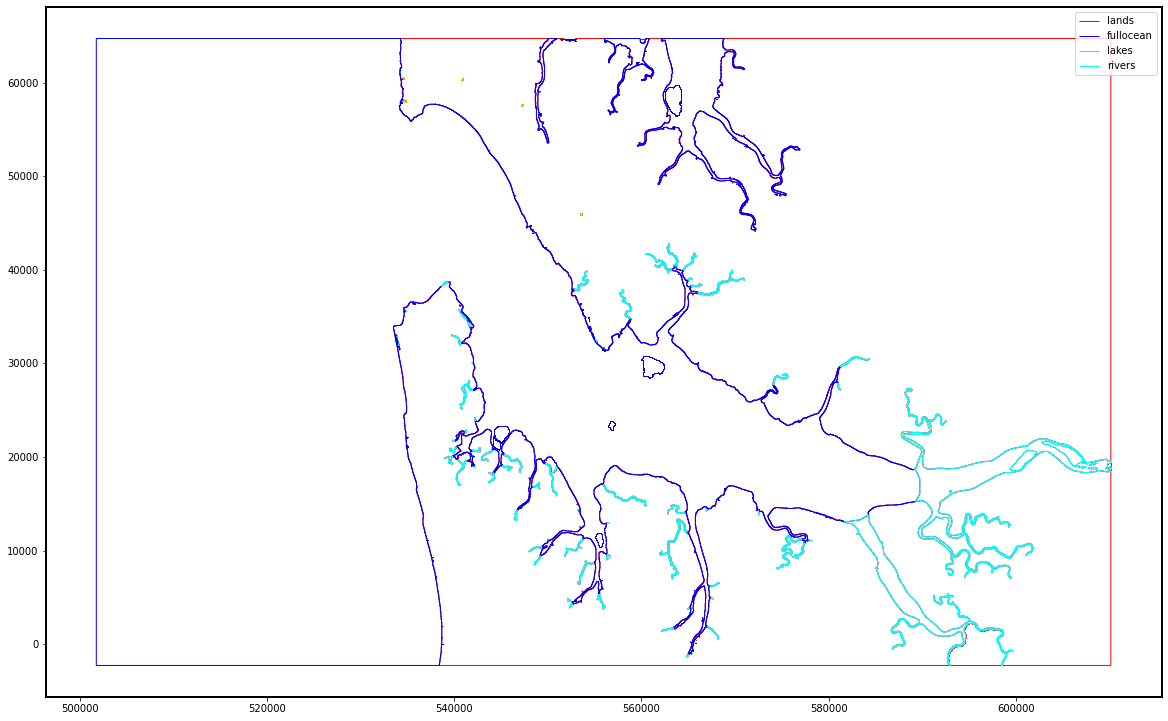

In [20]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    i=i+1
plt.legend()


In [21]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size='5' color = 'red' > Building the DEM STEP #5: <br> Using Orinoco, get distance and width files of the river networks</font>


In [22]:
segment_width = 150
pixel_step = int(round(segment_width/res))
distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,False)





##############################################################################################
##############################[Step 5][Make_Channel_Networks]#################################
##############################################################################################


[Step 5][Make_Channel_Networks][Import river mask (30m)] .......


[Step 5][Make_Channel_Networks][Import ocean mask (30m)] .......


[Step 5][Make_Channel_Networks][Use Orinoco code (Charlie) to get distance and widths of rivers] .......

##################### Pixel step will be 5
##################### Therefore, segments will be 30 * 5 = 150m wide

[Step 5][Make_Channel_Networks][Orinoco] .......


######[Make_Channel_Networks][Orinoco --> get_distance_in_channel] .......


######[Make_Channel_Networks][Orinoco --> get_distance_segments] .......


######[Make_Channel_Networks][Orinoco --> segment raster to shapefile] .......


######[Make_Channel_Networks][Orinoco --> get_undirected_channel_network]

adding edges: 100%|██████████| 2427/2427 [00:00<00:00, 112770.59it/s]



######[Make_Channel_Networks][Orinoco --> add_flow_attributes] .......



flow vector computation using network: 100%|██████████| 2267/2267 [00:00<00:00, 5794.14it/s]



######[Make_Channel_Networks][Orinoco --> get_geo_width_df] .......


######[Make_Channel_Networks][Orinoco --> update_graph_with_widths] .......


######[Make_Channel_Networks][Orinoco --> export_edges_to_geodataframe] .......


######[Make_Channel_Networks][Orinoco --> export_nodes_to_geodataframe] .......


######[Make_Channel_Networks][Orinoco --> get_width_features_from_segments] .......


######[Make_Channel_Networks][Orinoco --> get_array_from_features] .......


[Step 5][Make_Channel_Networks][Finished] .......



<font size='5' color = 'red' > Building the DEM STEP #7: <br> Make the Digital Elevation Model </font>


In [24]:
elevation,elev_name = make_model_foundation(mounted_drive,
                                                parameters,
                                                AOI,
                                                folders,
                                                ref,
                                                distance,
                                                widths,
                                                watermask,pixel_step,mounted_drive)





##############################################################################################
###############################[Step 6][Make_Model_Foundation]################################
##############################################################################################


[Step 6][Make_Model_Foundation][Determine all methods for calculating elevation for each land/water type] .......

##################### Method for land = GLO30
##################### Method for ocean = GEBCO
##################### Method for lower river reaches = plane
##################### Method for upper river reaches = wdpower
##################### Method for lakes = constant_1
##################### Method for wetlands = constant_0.5
##################### Max Depth for Rivers = -300
##################### Max Depth for Oceans = -300
##################### Max Depth for Nearshore = -300
##################### Boundary between Upper and Lower river reaches =  1260m
/content/drive/MyDrive/komo/DEMs/Eleva

<font size=5 color='green'> We will use the elevation file in later notebooks. </font>

In [25]:
print(elev_name)


Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30


<font size=5 color='red'> Done building DEM and other ancillary files. Move on to the next notebook 3_GetBoundaries.ipynb </font>
